In [1]:
%load_ext autoreload
%autoreload 2

import json

import numpy as np

from scipy import stats

from pathlib import Path

from overcast import models
from overcast import datasets
from overcast.models import ensembles
from overcast.visualization import plotting

import seaborn as sns
import matplotlib.pyplot as plt

rc = {
    "figure.constrained_layout.use": True,
    "figure.facecolor": "white",
    "axes.labelsize": 20,
    "axes.titlesize": 18,
    "legend.frameon": True,
    "figure.figsize": (6, 6),
    "legend.fontsize": 18,
    "legend.title_fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
}
_ = sns.set(style="whitegrid", palette="colorblind", rc=rc)

In [2]:
experiment_dir = Path("/users/ms21mmso/msc-project/overcast/output/jasmin-daily-hr_treatment-MERRA_aod_covariates-MERRA_RH950-MERRA_RH850-MERRA_RH700-MERRA_LTS-MERRA_W500-ERA_sst_outcomes-Cloud_Effective_Radius-Cloud_Optical_Thickness-Cloud_Water_Path_bins-1_bs-False/appended-treatment-transformer/dh-256_nco-24_nct-24_dp-3_nh-4_ns-0.01_bt-0.0_ln-False_dr-0.5_sn-0.0_lr-0.0002_bs-32_ep-500")
config_path = experiment_dir / "config.json"
checkpoint_dir = experiment_dir = experiment_dir / "checkpoints"

In [3]:
with open(config_path) as cp:
    config = json.load(cp)

In [4]:
dataset_name = config.get("dataset_name")
num_components_outcome = config.get("num_components_outcome")
num_components_treatment = config.get("num_components_treatment")
dim_hidden = config.get("dim_hidden")
depth = config.get("depth")
num_heads = config.get("num_heads")
negative_slope = config.get("negative_slope")
beta = config.get("beta")
layer_norm = config.get("layer_norm")
dropout_rate = config.get("dropout_rate")
spectral_norm = config.get("spectral_norm")
learning_rate = config.get("learning_rate")
batch_size = config.get("batch_size")
epochs = config.get("epochs")
ensemble_size = config.get("ensemble_size")

In [5]:
config["ds_test"]["root"] = "/users/ms21mmso/msc-project/overcast/data/MERRA_25kmres_2003.csv"
config["ds_valid"]["root"] = "/users/ms21mmso/msc-project/overcast/data/MERRA_25kmres_2003.csv"
config["ds_train"]["root"] = "/users/ms21mmso/msc-project/overcast/data/MERRA_25kmres_2003.csv"
ds = {
    "test": datasets.DATASETS.get(dataset_name)(**config.get("ds_test")),
    "valid": datasets.DATASETS.get(dataset_name)(**config.get("ds_valid")),
    "train": datasets.DATASETS.get(dataset_name)(**config.get("ds_train")),
}

In [6]:
TARGET_KEYS = dict((k, v) for (k,v) in enumerate(ds["test"].target_names))

In [7]:
ensemble = []
for ensemble_id in range(ensemble_size):
    model_dir = checkpoint_dir / f"model-{ensemble_id}" / "mu"
    model = models.AppendedTreatmentAttentionNetwork(
        job_dir=model_dir,
        dim_input=ds["train"].dim_input,
        dim_treatment=ds["train"].dim_treatments,
        dim_output=ds["train"].dim_targets,
        num_components_outcome=num_components_outcome,
        num_components_treatment=num_components_treatment,
        dim_hidden=dim_hidden,
        depth=depth,
        num_heads=num_heads,
        negative_slope=negative_slope,
        beta=beta,
        layer_norm=layer_norm,
        spectral_norm=spectral_norm,
        dropout_rate=dropout_rate,
        num_examples=len(ds["train"]),
        learning_rate=learning_rate,
        batch_size=batch_size,
        epochs=epochs,
        patience=50,
        num_workers=0,
        seed=ensemble_id,
    )
    model.load()
    ensemble.append(model)

2022-06-27 12:52:26,782 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /users/ms21mmso/msc-project/overcast/output/jasmin-daily-hr_treatment-MERRA_aod_covariates-MERRA_RH950-MERRA_RH850-MERRA_RH700-MERRA_LTS-MERRA_W500-ERA_sst_outcomes-Cloud_Effective_Radius-Cloud_Optical_Thickness-Cloud_Water_Path_bins-1_bs-False/appended-treatment-transformer/dh-256_nco-24_nct-24_dp-3_nh-4_ns-0.01_bt-0.0_ln-False_dr-0.5_sn-0.0_lr-0.0002_bs-32_ep-500/checkpoints/model-0/mu/best_checkpoint.pt
2022-06-27 12:52:27,120 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /users/ms21mmso/msc-project/overcast/output/jasmin-daily-hr_treatment-MERRA_aod_covariates-MERRA_RH950-MERRA_RH850-MERRA_RH700-MERRA_LTS-MERRA_W500-ERA_sst_outcomes-Cloud_Effective_Radius-Cloud_Optical_Thickness-Cloud_Water_Path_bins-1_bs-False/appended-treatment-transformer/dh-256_nco-24_nct-24_dp-3_nh-4_ns-0.01_bt-0.0_ln-False_dr-0.5_sn-0.0_lr-0.0002_bs-32_ep-500/ch

## Scatterplots 

In [8]:
means_ensemble = ensembles.predict_mean(ensemble, ds["test"], batch_size=None)
df_test = ds["test"].data_frame
observed_outcomes = df_test.to_numpy()[:, -4:]

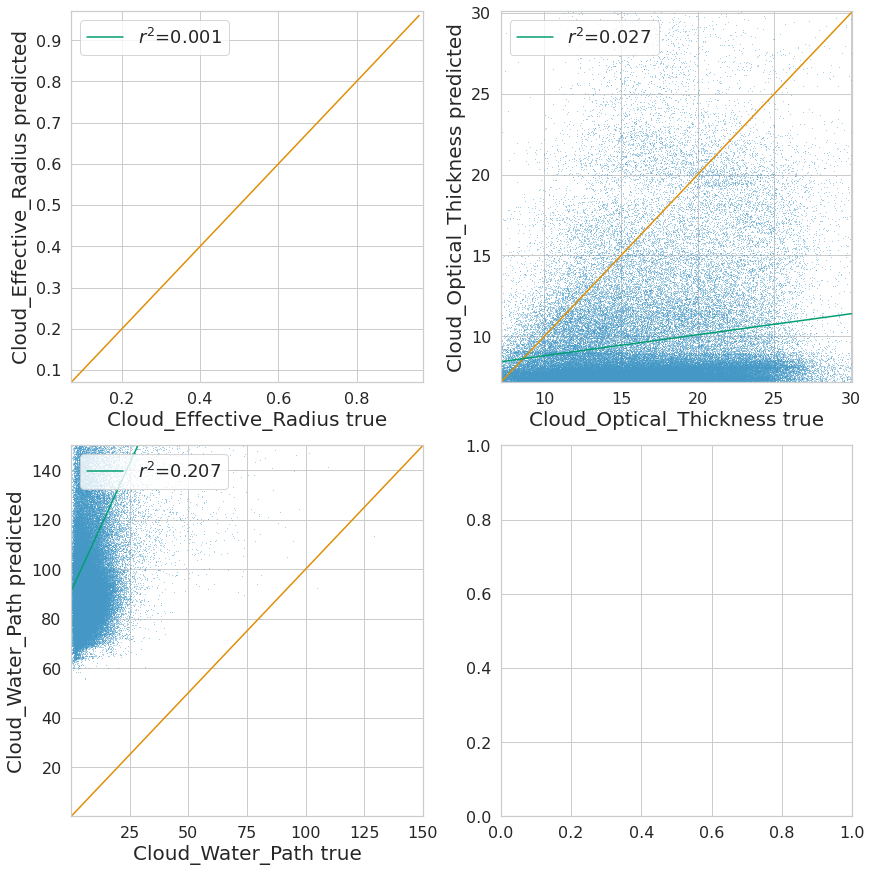

In [21]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

idx_outcome = 0
qs = np.quantile(observed_outcomes[:, idx_outcome], [0, 1])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax1)
_ = ax1.plot(domain, domain, c="C1")
_ = ax1.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax1.set_xlim(qs)
_ = ax1.set_ylim(qs)
_ = ax1.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax1.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax1.legend(loc="upper left")

idx_outcome = 1
qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.99])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax2)
_ = ax2.plot(domain, domain, c="C1")
_ = ax2.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax2.set_xlim(qs)
_ = ax2.set_ylim(qs)
_ = ax2.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax2.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax2.legend(loc="upper left")

idx_outcome = 2
qs = np.quantile(observed_outcomes[:, idx_outcome], [0, 1])
domain = np.arange(qs[0], qs[1], 0.01)
slope, intercept, r, p, stderr = stats.linregress(
    observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
)
_ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax3)
_ = ax3.plot(domain, domain, c="C1")
_ = ax3.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
_ = ax3.set_xlim(qs)
_ = ax3.set_ylim(qs)
_ = ax3.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
_ = ax3.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
_ = ax3.legend(loc="upper left")

# idx_outcome = 3
# qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.99])
# domain = np.arange(qs[0], qs[1], 0.01)
# slope, intercept, r, p, stderr = stats.linregress(
#     observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
# )
# _ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax4)
# _ = ax4.plot(domain, domain, c="C1")
# _ = ax4.plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
# _ = ax4.set_xlim(qs)
# _ = ax4.set_ylim(qs)
# _ = ax4.set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
# _ = ax4.set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
# _ = ax4.legend(loc="upper left")

## $\Lambda  \to 1.0$

In [10]:
treatments = np.concatenate(ds["train"].treatments, axis=0)
treatments = ds["train"].treatments_xfm.inverse_transform(treatments)
treatments = np.quantile(
    treatments,
    q=np.arange(0, 1 + 1 / 32, 1 / 32),
)[:-1]
apos_ensemble_path = Path("apos_ensemble.npy")
# if not apos_ensemble_path.exists():
capos_ensemble = ensembles.predict_capos(
    ensemble=ensemble, 
    dataset=ds["test"], 
    treatments=treatments, 
    batch_size=20000,
)
apos_ensemble = capos_ensemble.mean(2)
np.save(apos_ensemble_path, apos_ensemble)
# else:
#     apos_ensemble = np.load(apos_ensemble_path)

IndexError: index 3 is out of bounds for axis 0 with size 3

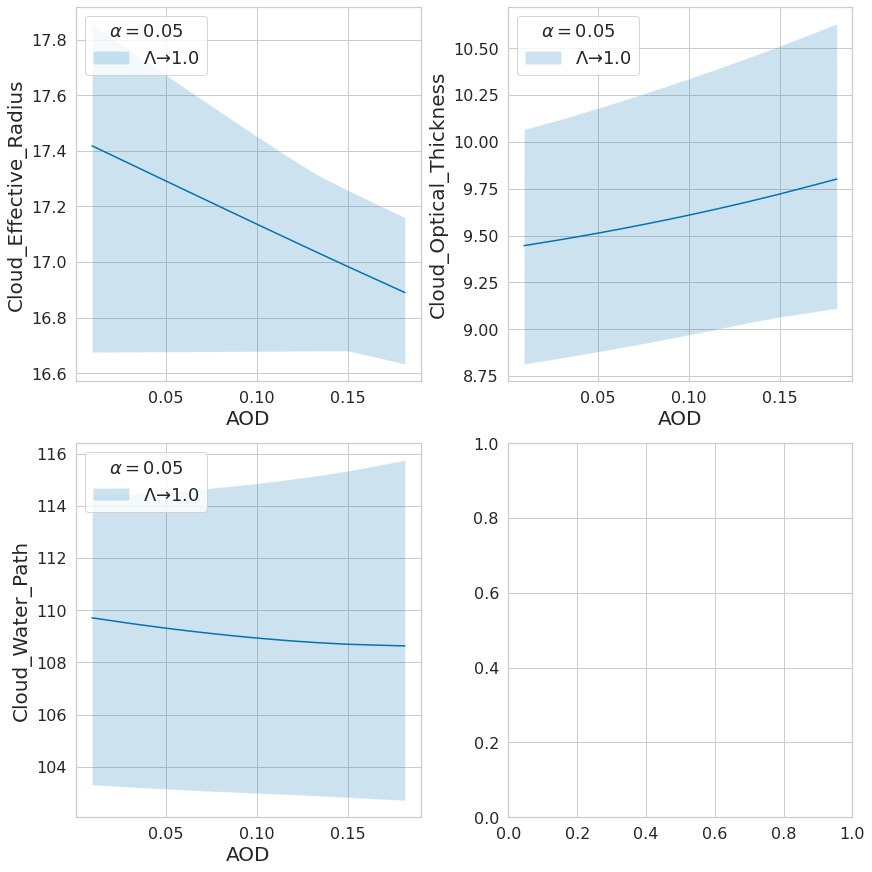

In [11]:
alpha = 0.05

_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

idx_outcome = 0
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax1)
_ = ax1.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0 $",
)
_ = ax1.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax1.set_ylabel(TARGET_KEYS[idx_outcome])
_ = ax1.set_xlabel("AOD")

idx_outcome = 1
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax2)
_ = ax2.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0 $",
)
_ = ax2.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax2.set_ylabel(TARGET_KEYS[idx_outcome])
_ = ax2.set_xlabel("AOD")


idx_outcome = 2
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax3)
_ = ax3.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0 $",
)
_ = ax3.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax3.set_ylabel(TARGET_KEYS[idx_outcome])
_ = ax3.set_xlabel("AOD")

idx_outcome = 3
_ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax4)
_ = ax4.fill_between(
    x=treatments,
    y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
    y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
    alpha=0.2,
    label=r"$\Lambda \to 1.0 $",
)
_ = ax4.legend(
    title=r"$\alpha=$" + f"{alpha}",
    loc="upper left",
)
_ = ax4.set_ylabel(TARGET_KEYS[idx_outcome])
_ = ax4.set_xlabel("AOD")